In [ ]:
#!pip install PySpice
#!pyspice-post-installation --install-ngspice-dll
#!pyspice-post-installation --check-install

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import numpy as np
import math
import concurrent.futures
import matplotlib as mpl
import matplotlib.gridspec as gridspec

In [2]:
# Values

R_head = 1e12       # Ohms    --- 1 T ohm
C_head = 1e-14      # Farads  --- 0.01 p F


R_base = 2e8        # Ohms    --- 200 M ohm
C_base = 5e-11      # Farads  --- 0.05 n F


In [3]:
base = 10 ** np.arange(2, 17)[:, None]
Rneck1 = np.sort((base * np.array([1, 2, 5])).flatten()).astype(int)
Rneck1 = np.sort(np.append(Rneck1, 800000000))

In [4]:
Tau_0 = []
Tau_1 = []
for Rneck4 in Rneck1:
    Tau_0.append(0.01)
    Tau_1.append((0.01*Rneck4)/(R_head+R_base + Rneck4))

In [5]:
def alpha(R_neck, R_base, R_head):
    return ((R_base * (R_head + R_neck + R_base)) / ((R_head + R_base) * (R_neck + R_base )))


alpha_Rneck = [alpha(x, R_base, R_head) for x in Rneck1]
beta_Rneck = [1-alpha(x, R_base, R_head) for x in Rneck1]

In [6]:
def dual_exponential(t, tau0, tau1, alpha):
    exp_part = (alpha * (1 - np.exp(-t / tau0))) + ((1-alpha) * (1 - np.exp(-t / tau1)))
    return exp_part


t = np.linspace(0, 0.1, 500)
Tau_eff = []
for i in range(len(Rneck1)):
    V = dual_exponential(t, tau0=Tau_0[i], tau1=Tau_1[i], alpha=alpha_Rneck[i])
    index = np.where(np.array(V) >= float(np.max(V)*0.632))[0][0]
    Tau = t[index+0]
    Tau_eff.append(Tau)


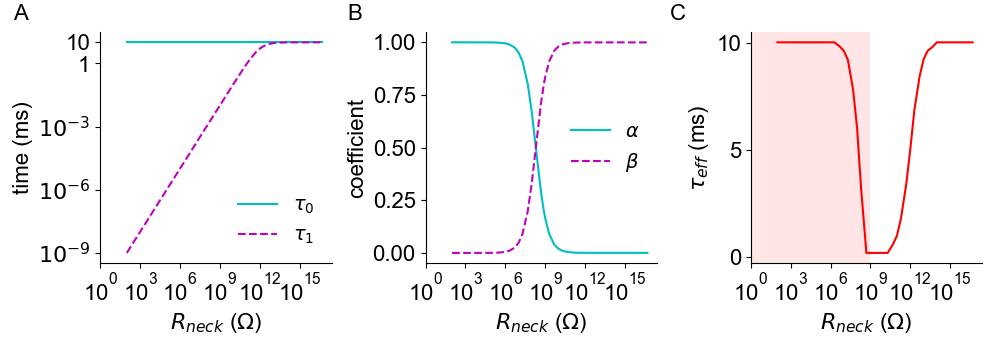

In [7]:
fig = plt.figure(figsize=(10, 3.6))
ax = fig.add_subplot(1, 3, 1)
ax.plot(Rneck1, Tau_0, 'c', label=r'$\tau_0$')
ax.plot(Rneck1, Tau_1, 'm--', label=r'$\tau_1$')
ax.set_xlabel('$R_{neck}$ ($\Omega$)', fontsize=16, family='Arial')
ax.set_ylabel('time (ms)', fontsize=16, family='Arial')
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.set_box_aspect(1)
plt.xticks(family='Arial'); plt.yticks(family='Arial')
plt.tick_params(axis="x", labelsize=16); plt.tick_params(axis="y", labelsize=16)
plt.xscale('log'); plt.yscale('log')
plt.xticks([1, 1000, 1_000_000, 1_000_000_000, 1_000_000_000_000 , 1_000_000_000_000_000 ])
yticks = [1e-2, 1e-3, 1e-6, 1e-9, 1e-12]
ytick_labels = ['10', '1'] + [r'$10^{%d}$' % int(np.log10(y*1000)) for y in yticks[2:]]
plt.yticks(yticks, ytick_labels)
plt.legend(fontsize=14, frameon=False)


ax = fig.add_subplot(1, 3, 2)
ax.plot(Rneck1, alpha_Rneck, 'c', label=r'$\alpha$')
ax.plot(Rneck1, beta_Rneck, 'm--', label=r'$\beta$')
ax.set_xlabel('$R_{neck}$ ($\Omega$)', fontsize=16, family='Arial')
ax.set_ylabel('coefficient', fontsize=16, family='Arial')
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.set_box_aspect(1)
plt.xticks(family='Arial'); plt.yticks(family='Arial')
plt.tick_params(axis="x", labelsize=16); plt.tick_params(axis="y", labelsize=16)
plt.xscale('log')
plt.xticks([1, 1000, 1_000_000, 1_000_000_000, 1_000_000_000_000 , 1_000_000_000_000_000 ])
plt.legend(fontsize=14, frameon=False)

ax = fig.add_subplot(1, 3, 3)
ax.plot(Rneck1, Tau_eff, 'r')
xmin, xmax = ax.get_xlim()
ax.axvspan(xmin, 1e9, facecolor=(1, 0, 0, 0.10), edgecolor='none', zorder=0)
ax.set_xlabel('$R_{neck}$ ($\Omega$)', fontsize=16, family='Arial')
ax.set_ylabel(r'$\tau_{eff}$ (ms)', fontsize=16, family='Arial')
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.set_box_aspect(1)
plt.xticks(family='Arial'); plt.yticks(family='Arial')
plt.tick_params(axis="x", labelsize=16); plt.tick_params(axis="y", labelsize=16)
plt.xscale('log')
plt.xticks([1, 1000, 1_000_000, 1_000_000_000, 1_000_000_000_000 , 1_000_000_000_000_000 ])
plt.yticks([0, 0.005, 0.010], [0, 5, 10])

plt.tight_layout()

plt.annotate('A', xy=(0.02,.92), xycoords='figure fraction', ha='center', va='center', fontsize=16, family='Arial');
plt.annotate('B', xy=(0.355,0.92), xycoords='figure fraction', ha='center', va='center', fontsize=16, family='Arial');
plt.annotate('C', xy=(0.678,0.92), xycoords='figure fraction', ha='center', va='center', fontsize=16, family='Arial');


# fig.savefig('Theory_Time_Constants_Graphs.pdf')
# fig.savefig('Theory_Time_Constants_Graphs.png')

# Numerical Simulation - SPICE

In [8]:
def run_simulation(Rneck2):
    num_segments = 500

    R_dend = 200000 * (2*num_segments+1)
    C_dend = 0.00005 / (2*num_segments+1)

    Raxial = 5_000@u_kΩ
    Cseg = C_dend@u_uF # 0.0002
    Rseg = R_dend@u_kΩ # 100000
    #
    circuit = Circuit('RC Circuit with Step Input')
    circuit.I('input', circuit.gnd, 'node1', 'PULSE(0A .0000001A 0.0ms 0ns 0ns 0ms 200s)')
    circuit.R('Rhead', 'node1', circuit.gnd, 1000000000@u_kΩ)
    circuit.C('Chead', 'node1', circuit.gnd, 0.00000001@u_uF)
    circuit.R('Rneck', 'node1', 'node2', Rneck2@u_Ω)
    circuit.R('Rbase', 'node2', circuit.gnd, Rseg) # @u_kΩ
    circuit.C('Cbase', 'node2', circuit.gnd, Cseg) # @u_uF
    
    # ADD SEGMENTS TO THE RIGHT of node2
    prev_node = 'node2'
    for i in range(3, num_segments + 3):  # node3 to node12
        new_node = f'nodeR_{i}'
        circuit.R(f'RaxialR_{i}', prev_node, new_node, Raxial)
        circuit.R(f'RsegR_{i}', new_node, circuit.gnd, Rseg)
        circuit.C(f'CsegR_{i}', new_node, circuit.gnd, Cseg)
        prev_node = new_node

    # ADD SEGMENTS TO THE LEFT of node2
    prev_node = 'node2'
    for i in range(1, num_segments + 1):  # nodeL_1 to nodeL_10
        new_node = f'nodeL_{i}'
        circuit.R(f'RaxialL_{i}', prev_node, new_node, Raxial)
        circuit.R(f'RsegL_{i}', new_node, circuit.gnd, Rseg)
        circuit.C(f'CsegL_{i}', new_node, circuit.gnd, Cseg)
        prev_node = new_node

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=0.1@u_ms, end_time=100@u_ms)
    
    index = np.where(np.array(analysis.node1) >= float(np.max(analysis.node1) * 0.632))[0][0]
    time_at_63_percent = analysis.time[index]
    
    Current_amp = (analysis.node1[-1] - analysis.node2[-1]) / Rneck2
    Charge = np.sum((analysis.node1 - analysis.node2) / Rneck2)
    
    return Rneck2, float(time_at_63_percent) * 1000, analysis.time, analysis.node1, Current_amp, Charge  # Tau in ms


In [9]:
volt_traces = {}
time_traces = {}
Tau_eff_sim2 = {}
Currents = {}
Charges = {}

with concurrent.futures.ProcessPoolExecutor() as exe:
    # run_simulation executed in parallel for every Rneck
    for rneck_ohm, tau_ms, t_arr, v_arr, Current_amp, Charge in exe.map(run_simulation, Rneck1):
        time_traces[rneck_ohm] = t_arr
        volt_traces[rneck_ohm] = v_arr
        Tau_eff_sim2[rneck_ohm] = tau_ms
        Currents[rneck_ohm] = Current_amp
        Charges[rneck_ohm] = Charge



Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36
Unsupported Ngspice version 36


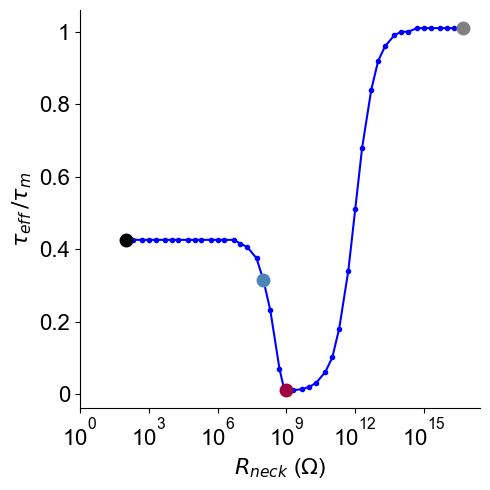

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot([r for r in Rneck1], [Tau_eff_sim2[r] for r in Rneck1], '.-b')

MS = 18
ax.plot(100, Tau_eff_sim2[100], color='k', marker='.', markersize=MS)
ax.plot(50_000_000_000_000_000, Tau_eff_sim2[50_000_000_000_000_000], color='gray', marker='.', markersize=MS)
ax.plot(100_000_000, Tau_eff_sim2[100_000_000], color='#4b85b7', marker='.', markersize=MS)
ax.plot(1_000_000_000, Tau_eff_sim2[1_000_000_000], color='#9e0142', marker='.', markersize=MS)
ax.set_xlabel('$R_{neck}$ ($\Omega$)', fontsize=16, family='Arial')
ax.set_ylabel(r'$\tau_{eff}\,/\tau_m$', fontsize=16, family='Arial')
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.xticks(family='Arial'); plt.yticks(family='Arial')
plt.tick_params(axis="x", labelsize=16); plt.tick_params(axis="y", labelsize=16)
plt.xscale('log')
plt.xticks([1, 1000, 1_000_000, 1_000_000_000, 1_000_000_000_000 , 1_000_000_000_000_000 ])
plt.yticks([0, 2, 4, 6, 8, 10], [0, 0.2, 0.4, 0.6, 0.8, 1])
plt.tight_layout()

#fig.savefig('Tau_Rneck_dend_400seg_Raxial_5M.pdf') 

# Effective time constant in a spine coupled to a dendritic cable

In [11]:
def erf_vec(x: np.ndarray) -> np.ndarray:
    if hasattr(np, "erf"):         
        return np.erf(x)
    else:                           
        from math import erf as _erf
        return np.vectorize(_erf)(x)
    
def dual_exponential(t, tau0, tau1, alpha):
    exp_part = (alpha * (1 - np.exp(-t / tau1))) + ((1-alpha) * (1 - np.exp(-t / tau0)))
    return exp_part


y_iso = dual_exponential(np.array(time_traces[100]), tau0=0.02, tau1=0.02, alpha=0)
y_zero = erf_vec(np.sqrt(np.array(time_traces[100])/0.02))


In [12]:
# For Arial text into Latex expressions
mpl.rcParams.update({
    'font.family'      : 'Arial',   # normal text
    'mathtext.fontset' : 'custom',  # allow custom TTF
    'mathtext.rm'      : 'Arial',
})


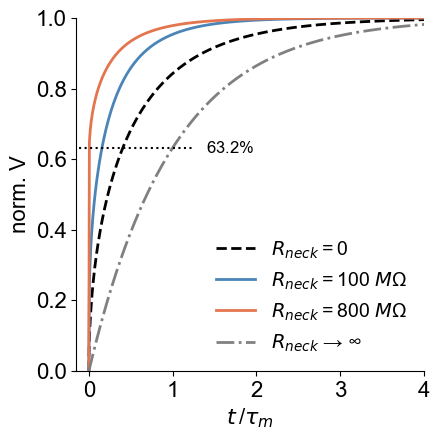

In [13]:
## Simulations
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(time_traces[100]*1000, y_zero, color='k', linestyle='--', lw=2, label=r'$R_{neck}=0$')
ax.plot(time_traces[100_000_000]*1000, volt_traces[100_000_000]/np.max(volt_traces[100_000_000]), color='#4b85b7', lw=2, label='$R_{neck}=100\;M\Omega$')
#ax.plot(time_traces[1_000_000_000]*1000, volt_traces[1_000_000_000]/np.max(volt_traces[1_000_000_000]), color='#9e0142', lw=2, label='$R_{neck}=1\;G\Omega$')
ax.plot(time_traces[800_000_000]*1000, volt_traces[800_000_000]/np.max(volt_traces[800_000_000]), color='#e3754f', lw=2, label='$R_{neck}=800\;M\Omega$')
ax.plot(time_traces[100]*1000, y_iso, color='gray', linestyle='-.', lw=2, label=r'$R_{neck}\;\to\; \infty$')

ax.plot([-5, 25], [0.632, 0.632], color='k', ls=':', lw=1.5)
ax.text(28, 0.632, r'$63.2\%$', family='arial', va='center', ha='left', fontsize=12)

ax.set_xlim([-3,80])
ax.set_ylim([0,1])
ax.set_xlabel(r"$t\,/\tau_m$", fontsize=16, family='Arial')
ax.set_ylabel("norm. V", fontsize=16, family='Arial')
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
legend = ax.legend(fontsize=14, frameon=False)

plt.xticks(family='Arial'); plt.yticks(family='Arial')
plt.tick_params(axis="x", labelsize=16); plt.tick_params(axis="y", labelsize=16)
plt.xticks([0, 20, 40, 60, 80 ], [0,1,2,3,4])
plt.tight_layout()
#plt.grid(True)

plt.show()
#fig.savefig('Rall_and_Spine_Time_Constant_SIMULATIONS.pdf')

# Biophysical Interpretation of the Biphasic Dependence of the effective Tau

In [14]:
def current_dividor(R_neck, R_base, R_head):
    return R_head/(R_head + R_neck + R_base)

Current_div = [current_dividor(x, R_base, R_head) for x in Rneck1]
#Current_div

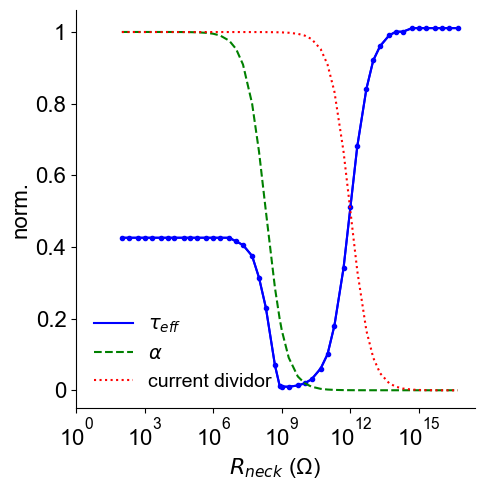

In [15]:
# Current
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot([r for r in Rneck1], [Tau_eff_sim2[r]/10 for r in Rneck1], 'b', label=r'$\tau_{eff}$')
ax.plot([r for r in Rneck1], [Tau_eff_sim2[r]/10 for r in Rneck1], '.-b')
ax.plot([r for r in Rneck1], alpha_Rneck, '--g', label=r'$\alpha$')
ax.plot([r for r in Rneck1], Current_div, ':r', label='current dividor')

ax.set_xlabel('$R_{neck}$ ($\Omega$)', fontsize=16, family='Arial')
ax.set_ylabel('norm.', fontsize=16, family='Arial')
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
ax.set_box_aspect(1)

plt.xticks(family='Arial'); plt.yticks(family='Arial')
plt.tick_params(axis="x", labelsize=16); plt.tick_params(axis="y", labelsize=16)
plt.xscale('log')
plt.xticks([1, 1000, 1_000_000, 1_000_000_000, 1_000_000_000_000 , 1_000_000_000_000_000 ])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
plt.legend(fontsize=14, loc="lower left", frameon=False)
plt.tight_layout()

#fig.savefig('spine_explanation1.pdf')